In [1]:
%load_ext autoreload
%autoreload 2

from vlstm_spec import *
from music_dataset import TorchMusicDataset

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchaudio.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import numpy as np
from scipy.io.wavfile import write
    
from scipy.signal import resample, firwin, lfilter

import librosa


dataset = TorchMusicDataset("../dataset/cleaned_data/cleaned_data")

In [2]:
def downsample_audio(audio, original_rate, new_rate):
    factor = original_rate // new_rate
    
    nyquist_rate = original_rate / 2
    cutoff_freq = new_rate / 2
    numtaps = 101 
    fir_coeff = firwin(numtaps, cutoff_freq / nyquist_rate)
    filtered_audio = lfilter(fir_coeff, 1.0, audio)
    
    downsampled_audio = filtered_audio[::factor]
    
    return downsampled_audio

In [3]:
songs = []
for i in range(100):
    obj = dataset.__getitem__(i)
    song = obj['time_series'].numpy()
    downsampled_song = downsample_audio(song, 44100, 11025)
    songs.append(downsampled_song[:11025*5])
    

In [4]:
batch_size = 4
n_in = songs[0].shape[0]
hidden_size = 5
songs = np.array(songs)
sample_rate = 22050
features = 32
latent_dim = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
dataloader = create_dataloader(songs, sample_rate, batch_size, n_in)
    
vae = VAE(n_in, features, latent_dim, device, hidden_size).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
vae.optimizer = optimizer

lossGraph = []
# Training loop
epochs = 100
for epoch in range(epochs):
    epoch_loss = 0
    num_batches = 0
    
    for batch_x, _ in dataloader:
        batch_x = batch_x.to(device)
        loss = vae.training_step(batch_x)
        
        epoch_loss += loss
        num_batches += 1
    
    average_loss = epoch_loss / num_batches
    lossGraph.append(average_loss)
    
    print(f'Epoch {epoch+1}, Average Loss: {average_loss:.4f}')

Epoch 1, Average Loss: 265.4500
Epoch 2, Average Loss: 265.4086
Epoch 3, Average Loss: 265.3766
Epoch 4, Average Loss: 265.3511
Epoch 5, Average Loss: 265.3251
Epoch 6, Average Loss: 265.3025
Epoch 7, Average Loss: 265.2831
Epoch 8, Average Loss: 265.2644
Epoch 9, Average Loss: 265.2477
Epoch 10, Average Loss: 265.2303
Epoch 11, Average Loss: 265.2237
Epoch 12, Average Loss: 265.2169
Epoch 13, Average Loss: 265.2076
Epoch 14, Average Loss: 265.2047
Epoch 15, Average Loss: 265.2054
Epoch 16, Average Loss: 265.2023
Epoch 17, Average Loss: 265.1981
Epoch 18, Average Loss: 265.1976
Epoch 19, Average Loss: 265.1948
Epoch 20, Average Loss: 265.1957
Epoch 21, Average Loss: 265.1984
Epoch 22, Average Loss: 265.1964
Epoch 23, Average Loss: 265.1960
Epoch 24, Average Loss: 265.1957
Epoch 25, Average Loss: 265.1966
Epoch 26, Average Loss: 265.1962
Epoch 27, Average Loss: 265.1952
Epoch 28, Average Loss: 265.1969
Epoch 29, Average Loss: 265.1944
Epoch 30, Average Loss: 265.1981
Epoch 31, Average L

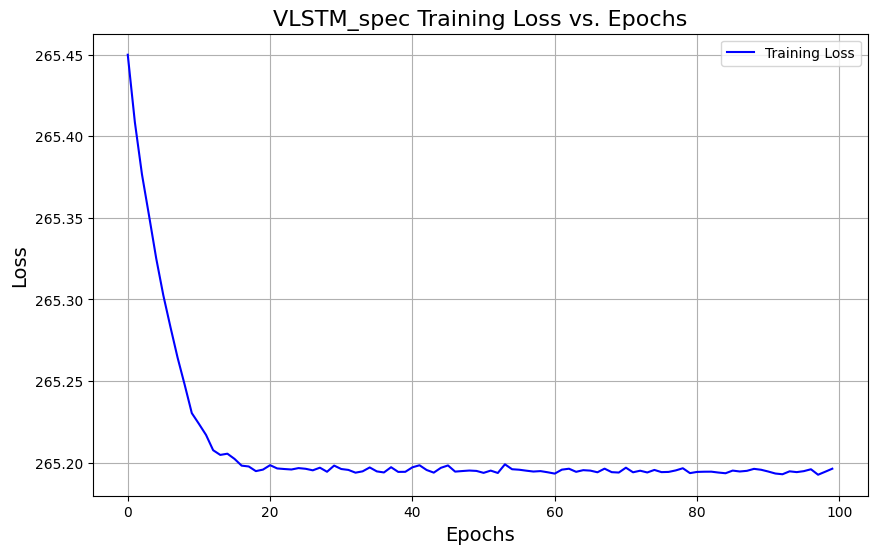

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(lossGraph, linestyle='-', color='b', label='Training Loss')

plt.title('VLSTM_spec Training Loss vs. Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()

plt.grid(True)

plt.show()

In [5]:
torch.save(vae, 'vlstm_spec.pt')

In [15]:
from scipy.io.wavfile import write

num_samples = 1
generated_sequences = vae.generate_sequences(num_samples)

spec = generated_sequences[0]
mel_inverted = librosa.feature.inverse.mel_to_stft(spec, sr=11025, n_fft=2048)
audio_array = librosa.griffinlim(mel_inverted, n_iter=32, hop_length=512, win_length=2048)
audio_array = audio_array / np.max(np.abs(audio_array))
audio_array = (audio_array * 32767).astype(np.int16)
sample_rate = 11025
output_filename = 'gen_audio_vlstm_spec_.wav'

write(output_filename, sample_rate, audio_array)

print(f"Audio saved as {output_filename}")

Audio saved as gen_audio_vlstm_spec_.wav
